In [346]:
#Store Item Demand Forecasting Challenge

In [347]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

In [348]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
warnings.filterwarnings('ignore')

In [349]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    # Sadece sayısal sütunları seçiyoruz
    numeric_cols = dataframe.select_dtypes(include=["number"])
    print(numeric_cols.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [350]:
train = pd.read_csv('demand_forecasting/train.csv',parse_dates=['date'])
test = pd.read_csv('demand_forecasting/test.csv',parse_dates=['date'])

#istenilen csv dosyası 
sample_sub = pd.read_csv('demand_forecasting/sample_submission.csv')

In [351]:
print(train.head())
print(test.head())

        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10
   id       date  store  item
0   0 2018-01-01      1     1
1   1 2018-01-02      1     1
2   2 2018-01-03      1     1
3   3 2018-01-04      1     1
4   4 2018-01-05      1     1


In [352]:
df=pd.concat([train,test],sort=False)
print(df.head())

        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN


In [353]:
#Exploratory Data Analysis
print(df['date'].min(), df['date'].max())
check_df(df)

2013-01-01 00:00:00 2018-03-31 00:00:00
##################### Shape #####################
(958000, 5)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
##################### NA #####################
date          0
store         0
item          0
sales     45000
id     

In [354]:
print(df['store'].nunique())
print(df['item'].nunique())
print(df.groupby(['store'])['item'].nunique())


10
50
store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64


In [355]:
print(df.groupby(['store','item']).agg({"sales": "sum"}))

               sales
store item          
1     1      36468.0
      2      97050.0
      3      60638.0
      4      36440.0
      5      30335.0
...              ...
10    46    120601.0
      47     45204.0
      48    105570.0
      49     60317.0
      50    135192.0

[500 rows x 1 columns]


In [356]:
df.groupby(['store','item']).agg({"sales": ["sum","mean","median","std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

In [357]:
#Feature Engineering
#Date Feature
def create_date_futures(df):
    df['month'] = df.date.dt.month.astype(int)
    df['day_of_month'] = df.date.dt.day.astype(int)
    df['day_of_year'] = df.date.dt.dayofyear.astype(int)
    df['week_of_year'] = df.date.dt.isocalendar().week.astype(int)
    df['day_of_week'] = df.date.dt.dayofweek.astype(int)
    df['year'] = df.date.dt.year.astype(int)
    df['is_wknd'] = (df.date.dt.weekday // 4 ).astype(int)
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

#sevgililer günü gibi özel günlerde de çıkarım yapılabilir lakin veri setinin uzunluğu dikkate alınmalıdır. Pattern oluşturmayacak kadar uzun değilse çıkarım yapılmayabilir.

In [358]:
print(df.columns)
df = create_date_futures(df)
print(df.columns)
print(df.groupby(["store","item","month"]).agg({"sales":["sum","mean","median","std"]}))

Index(['date', 'store', 'item', 'sales', 'id'], dtype='object')
Index(['date', 'store', 'item', 'sales', 'id', 'month', 'day_of_month',
       'day_of_year', 'week_of_year', 'day_of_week', 'year', 'is_wknd',
       'is_month_start', 'is_month_end'],
      dtype='object')
                    sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12

In [359]:
def random_noies(dataframe):
    return np.random.normal(scale=1.6,size=(len(dataframe),))

In [360]:
#Lag/Shifted Features
#referans noktası oluşturmak için
df.sort_values(by=['store','item','date'],inplace=True)
#lag feature mevsimselliği yakalamak için ve trendi gözlemlemek için kullanılır.
print(pd.DataFrame({"sales":df["sales"].values[0:10],
                    "lag1":df["sales"].shift(1).values[0:10],
                    "lag2":df["sales"].shift(2).values[0:10],
                    "lag3":df["sales"].shift(3).values[0:10],
                    "lag4":df["sales"].shift(4).values[0:10]}))
#shift feature -> gecikme 

   sales  lag1  lag2  lag3  lag4
0   13.0   NaN   NaN   NaN   NaN
1   11.0  13.0   NaN   NaN   NaN
2   14.0  11.0  13.0   NaN   NaN
3   13.0  14.0  11.0  13.0   NaN
4   10.0  13.0  14.0  11.0  13.0
5   12.0  10.0  13.0  14.0  11.0
6   10.0  12.0  10.0  13.0  14.0
7    9.0  10.0  12.0  10.0  13.0
8   12.0   9.0  10.0  12.0  10.0
9    9.0  12.0   9.0  10.0  12.0


In [361]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store","item"])['sales'].transform(
            lambda x: x.shift(lag))+random_noies(dataframe)
    return dataframe   

In [362]:
df=lag_features(df,[91,98,105,112,119,126,182,364,546,728]) 
#3 ayın katları ya da ara değerler seçildi, probleme göre
check_df(df)

##################### Shape #####################
(958000, 24)
##################### Types #####################
date              datetime64[ns]
store                      int64
item                       int64
sales                    float64
id                       float64
month                      int64
day_of_month               int64
day_of_year                int64
week_of_year               int64
day_of_week                int64
year                       int64
is_wknd                    int64
is_month_start             int64
is_month_end               int64
sales_lag_91             float64
sales_lag_98             float64
sales_lag_105            float64
sales_lag_112            float64
sales_lag_119            float64
sales_lag_126            float64
sales_lag_182            float64
sales_lag_364            float64
sales_lag_546            float64
sales_lag_728            float64
dtype: object
##################### Head #####################
        date  store  item  sales

In [363]:
#Rolling Mean Features
#rolling window -> hareketli pencere / kaç adım geriye gidileceği
print(pd.DataFrame({"sales":df["sales"].values[0:10],
                    "roll2":df["sales"].rolling(window=2).mean().values[0:10],
                    "roll3":df["sales"].rolling(window=3).mean().values[0:10],
                    "roll5":df["sales"].rolling(window=5).mean().values[0:10]}))


   sales  roll2      roll3  roll5
0   13.0    NaN        NaN    NaN
1   11.0   12.0        NaN    NaN
2   14.0   12.5  12.666667    NaN
3   13.0   13.5  12.666667    NaN
4   10.0   11.5  12.333333   12.2
5   12.0   11.0  11.666667   12.0
6   10.0   11.0  10.666667   11.8
7    9.0    9.5  10.333333   10.8
8   12.0   10.5  10.333333   10.6
9    9.0   10.5  10.000000   10.4


In [364]:
#hareketli ortalama feature alınırken mutlaka bir tane shift feature alınmalıdır.
print(pd.DataFrame({"sales":df["sales"].values[0:10],
                    "roll2":df["sales"].shift(1).rolling(window=2).mean().values[0:10],
                    "roll3":df["sales"].shift(1).rolling(window=3).mean().values[0:10],
                    "roll5":df["sales"].shift(1).rolling(window=5).mean().values[0:10]}))

   sales  roll2      roll3  roll5
0   13.0    NaN        NaN    NaN
1   11.0    NaN        NaN    NaN
2   14.0   12.0        NaN    NaN
3   13.0   12.5  12.666667    NaN
4   10.0   13.5  12.666667    NaN
5   12.0   11.5  12.333333   12.2
6   10.0   11.0  11.666667   12.0
7    9.0   11.0  10.666667   11.8
8   12.0    9.5  10.333333   10.8
9    9.0   10.5  10.333333   10.6


In [365]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store","item"])['sales'].transform(
            lambda x: x.shift(1).rolling(window=window, win_type="triang").mean())+random_noies(dataframe)
    return dataframe

In [366]:
df=roll_mean_features(df,[365,546])#bir yıl ve 1.5 yıl 
print(df.head())
#iki yeni feature oluşturuldu

        date  store  item  sales  id  month  day_of_month  day_of_year  \
0 2013-01-01      1     1   13.0 NaN      1             1            1   
1 2013-01-02      1     1   11.0 NaN      1             2            2   
2 2013-01-03      1     1   14.0 NaN      1             3            3   
3 2013-01-04      1     1   13.0 NaN      1             4            4   
4 2013-01-05      1     1   10.0 NaN      1             5            5   

   week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  \
0             1            1  2013        0               1             0   
1             1            2  2013        0               0             0   
2             1            3  2013        0               0             0   
3             1            4  2013        1               0             0   
4             1            5  2013        1               0             0   

   sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  \
0           Na

In [367]:
check_df(df)

##################### Shape #####################
(958000, 26)
##################### Types #####################
date                   datetime64[ns]
store                           int64
item                            int64
sales                         float64
id                            float64
month                           int64
day_of_month                    int64
day_of_year                     int64
week_of_year                    int64
day_of_week                     int64
year                            int64
is_wknd                         int64
is_month_start                  int64
is_month_end                    int64
sales_lag_91                  float64
sales_lag_98                  float64
sales_lag_105                 float64
sales_lag_112                 float64
sales_lag_119                 float64
sales_lag_126                 float64
sales_lag_182                 float64
sales_lag_364                 float64
sales_lag_546                 float64
sales_lag_728

In [368]:
#Exponentially Weighted Features 
pd.DataFrame({"sales":df["sales"].values[0:10],
               "roll2":df["sales"].shift(1).rolling(window=2).mean().values[0:10],
                "ewm099":df["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10],#en yakına en fazla ağırlık verir
                "ewm095":df["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
                "ewm07":df["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
                "ewm02":df["sales"].shift(1).ewm(alpha=0.2).mean().values[0:10]})

,sales,roll2,ewm099,ewm095,ewm07,ewm02
0,13.0,NaN,NaN,NaN,NaN,NaN
1,11.0,NaN,13.000000,13.000000,13.000000,13.000000
2,14.0,12.0,11.019802,11.095238,11.461538,11.888889
3,13.0,12.5,13.970201,13.855107,13.287770,12.754098
4,10.0,13.5,13.009702,13.042750,13.084686,12.837398
5,12.0,11.5,10.030097,10.152137,10.920146,11.993337
6,10.0,11.0,11.980301,11.907607,11.676595,11.995143
7,9.0,11.0,10.019803,10.095380,10.502722,11.490225
8,12.0,9.5,9.010198,9.054769,9.450748,10.891777
9,9.0,10.5,11.970102,11.852738,11.235259,11.147782


In [369]:
def evm_features(dataframe, alphas,lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_'+str(alpha).replace(".","")+'_lag_'+str(lag)] = \
                dataframe.groupby(["store","item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [370]:
alphas=[0.95,0.9,0.8,0.7,0.5]
lags=[91,98,105,112,180,270,365,546,728]
df=evm_features(df,alphas,lags)
print(df)

            date  store  item  sales       id  month  day_of_month  \
0     2013-01-01      1     1   13.0      NaN      1             1   
1     2013-01-02      1     1   11.0      NaN      1             2   
2     2013-01-03      1     1   14.0      NaN      1             3   
3     2013-01-04      1     1   13.0      NaN      1             4   
4     2013-01-05      1     1   10.0      NaN      1             5   
...          ...    ...   ...    ...      ...    ...           ...   
44995 2018-03-27     10    50    NaN  44995.0      3            27   
44996 2018-03-28     10    50    NaN  44996.0      3            28   
44997 2018-03-29     10    50    NaN  44997.0      3            29   
44998 2018-03-30     10    50    NaN  44998.0      3            30   
44999 2018-03-31     10    50    NaN  44999.0      3            31   

       day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  \
0                1             1            1  2013        0               1   

In [371]:
check_df(df)

##################### Shape #####################
(958000, 71)
##################### Types #####################
date                          datetime64[ns]
store                                  int64
item                                   int64
sales                                float64
id                                   float64
                                   ...      
sales_ewm_alpha_05_lag_180           float64
sales_ewm_alpha_05_lag_270           float64
sales_ewm_alpha_05_lag_365           float64
sales_ewm_alpha_05_lag_546           float64
sales_ewm_alpha_05_lag_728           float64
Length: 71, dtype: object
##################### Head #####################
        date  store  item  sales  id  month  day_of_month  day_of_year  \
0 2013-01-01      1     1   13.0 NaN      1             1            1   
1 2013-01-02      1     1   11.0 NaN      1             2            2   
2 2013-01-03      1     1   14.0 NaN      1             3            3   
3 2013-01-04      1  

In [372]:
#One-Hot Encoding
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])
print(df.head())

        date  sales  id  day_of_month  day_of_year  week_of_year  year  \
0 2013-01-01   13.0 NaN             1            1             1  2013   
1 2013-01-02   11.0 NaN             2            2             1  2013   
2 2013-01-03   14.0 NaN             3            3             1  2013   
3 2013-01-04   13.0 NaN             4            4             1  2013   
4 2013-01-05   10.0 NaN             5            5             1  2013   

   is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  \
0        0               1             0           NaN           NaN   
1        0               0             0           NaN           NaN   
2        0               0             0           NaN           NaN   
3        1               0             0           NaN           NaN   
4        1               0             0           NaN           NaN   

   sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  \
0            NaN            NaN           

In [373]:
check_df(df)

##################### Shape #####################
(958000, 146)
##################### Types #####################
date            datetime64[ns]
sales                  float64
id                     float64
day_of_month             int64
day_of_year              int64
                     ...      
month_8                   bool
month_9                   bool
month_10                  bool
month_11                  bool
month_12                  bool
Length: 146, dtype: object
##################### Head #####################
        date  sales  id  day_of_month  day_of_year  week_of_year  year  \
0 2013-01-01   13.0 NaN             1            1             1  2013   
1 2013-01-02   11.0 NaN             2            2             1  2013   
2 2013-01-03   14.0 NaN             3            3             1  2013   
3 2013-01-04   13.0 NaN             4            4             1  2013   
4 2013-01-05   10.0 NaN             5            5             1  2013   

   is_wknd  is_month_sta

In [374]:
#Convertirng Sales to Log(1+Sales)
#bağımlı değişkeni standartlaştırmak için 
#tercihe bağlıdır
#normalde ağaç veya sınıflandırma problemlerinde kullanılmaz
#istisna : ağaç tabanlı modellerde bagımlı degısken sayısalsa ya da \
#zaman serisi ise iterasyon süresini azaltmak için kullanılabilir
df['sales'] = np.log1p(df['sales'].values)

In [375]:
check_df(df)

##################### Shape #####################
(958000, 146)
##################### Types #####################
date            datetime64[ns]
sales                  float64
id                     float64
day_of_month             int64
day_of_year              int64
                     ...      
month_8                   bool
month_9                   bool
month_10                  bool
month_11                  bool
month_12                  bool
Length: 146, dtype: object
##################### Head #####################
        date     sales  id  day_of_month  day_of_year  week_of_year  year  \
0 2013-01-01  2.639057 NaN             1            1             1  2013   
1 2013-01-02  2.484907 NaN             2            2             1  2013   
2 2013-01-03  2.708050 NaN             3            3             1  2013   
3 2013-01-04  2.639057 NaN             4            4             1  2013   
4 2013-01-05  2.397895 NaN             5            5             1  2013   

   is_

In [377]:
#Custom cost function
#mae,mse,rmse,sse
#smape->symmetric mean absolute percentage error (adjusted mape)
#smape = 200/n * sum(|Ft - At| / (|Ft| + |At|))
# kayıp fonksiyonlarında gerçek değerler ile tahmin edilen değerler arasındaki farkları inceleriz. 
# smape de aynı amaçlı. 
# Düşük olması iyi birşey. 

#kaggleda paylaşılan smape fonksiyonu
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds==0) & (target==0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

In [378]:
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [381]:
#time-based validation sets

In [379]:
train

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [380]:
test #2018 in ilk 3 ayı bekleniyor 

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50


In [382]:
#2017 yılının başına kadar (2016 yılının sonuna kadar) train seti
train = df.loc[(df["date"] < "2017-01-01"), :]
#2017 nin ilk 3 ayı validation seti
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

#2018 in ilk 3 ayı istendiği için ona göre düşünülüp 2017 nin ilk 3 ayı validation seti seçildi

In [384]:
print(train)

             date     sales  id  day_of_month  day_of_year  week_of_year  \
0      2013-01-01  2.639057 NaN             1            1             1   
1      2013-01-02  2.484907 NaN             2            2             1   
2      2013-01-03  2.708050 NaN             3            3             1   
3      2013-01-04  2.639057 NaN             4            4             1   
4      2013-01-05  2.397895 NaN             5            5             1   
...           ...       ...  ..           ...          ...           ...   
912630 2016-12-27  4.110874 NaN            27          362            52   
912631 2016-12-28  3.784190 NaN            28          363            52   
912632 2016-12-29  4.234107 NaN            29          364            52   
912633 2016-12-30  4.158883 NaN            30          365            52   
912634 2016-12-31  4.174387 NaN            31          366            52   

        year  is_wknd  is_month_start  is_month_end  sales_lag_91  \
0       2013      

In [385]:
print(val)

             date     sales  id  day_of_month  day_of_year  week_of_year  \
1461   2017-01-01  2.995732 NaN             1            1            52   
1462   2017-01-02  2.772589 NaN             2            2             1   
1463   2017-01-03  2.397895 NaN             3            3             1   
1464   2017-01-04  2.833213 NaN             4            4             1   
1465   2017-01-05  2.708050 NaN             5            5             1   
...           ...       ...  ..           ...          ...           ...   
912720 2017-03-27  4.204693 NaN            27           86            13   
912721 2017-03-28  4.110874 NaN            28           87            13   
912722 2017-03-29  4.304065 NaN            29           88            13   
912723 2017-03-30  4.234107 NaN            30           89            13   
912724 2017-03-31  4.248495 NaN            31           90            13   

        year  is_wknd  is_month_start  is_month_end  sales_lag_91  \
1461    2017      

In [387]:
#bağımlı değişken sales
#bağımsız değişkenlerin seçimi
cols = [col for col in train.columns if col not in ['date', 'id', 'sales','year']]
print(cols)

['day_of_month', 'day_of_year', 'week_of_year', 'is_wknd', 'is_month_start', 'is_month_end', 'sales_lag_91', 'sales_lag_98', 'sales_lag_105', 'sales_lag_112', 'sales_lag_119', 'sales_lag_126', 'sales_lag_182', 'sales_lag_364', 'sales_lag_546', 'sales_lag_728', 'sales_roll_mean_365', 'sales_roll_mean_546', 'sales_ewm_alpha_095_lag_91', 'sales_ewm_alpha_095_lag_98', 'sales_ewm_alpha_095_lag_105', 'sales_ewm_alpha_095_lag_112', 'sales_ewm_alpha_095_lag_180', 'sales_ewm_alpha_095_lag_270', 'sales_ewm_alpha_095_lag_365', 'sales_ewm_alpha_095_lag_546', 'sales_ewm_alpha_095_lag_728', 'sales_ewm_alpha_09_lag_91', 'sales_ewm_alpha_09_lag_98', 'sales_ewm_alpha_09_lag_105', 'sales_ewm_alpha_09_lag_112', 'sales_ewm_alpha_09_lag_180', 'sales_ewm_alpha_09_lag_270', 'sales_ewm_alpha_09_lag_365', 'sales_ewm_alpha_09_lag_546', 'sales_ewm_alpha_09_lag_728', 'sales_ewm_alpha_08_lag_91', 'sales_ewm_alpha_08_lag_98', 'sales_ewm_alpha_08_lag_105', 'sales_ewm_alpha_08_lag_112', 'sales_ewm_alpha_08_lag_180', 

In [388]:
Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

In [389]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 142), (45000,), (45000, 142))

In [ ]:
#kıyaslama senaryosu oluşturmak kritik nokta 

In [395]:
#LightGBM ile zaman serisi modellemesi
#LightGBM -> hızlı, yüksek doğruluk, düşük bellek kullanımı
#gradient boosting temelli optimizasyon algoritması
#kategorik değişkenlerin otomatik olarak işlenmesi
#ağaç tabanlı modelleme

#kaggledan alınmıs parametreler
lgb_params = {'num_leaves': 10, #bir ağaçta olabilecek maksimum yaprak sayısı
            'learning_rate': 0.02, #öğrenme oranı , shrinkage_rate, eta
            "feature_fraction": 0.8, #rf'nin random subspace özelliği, her iterasyonda rastgele göz önünde bulundurulacak değişken sayısı
            'max_depth': 5, #ağacın maksimum derinliği
            'verbose': 0, #raporlama ifade eder
            'num_boost_round': 1000, #optimizasyon iterasyon sayısı, n_estimators, number of boosting iterations. En az 10000-15000 civarı yapmak lazım 
            'early_stopping_rounds': 200,
            'nthread': -1} #işlemci sayısı, num_thread, n_jobs,nthread, nthreads
#early_stopping_rounds -> validasyon setindeki metrik belirli bir early_stopping_rounds'da ilerlemiyorsa yani 
# hata oranı düşmüyorsa iterasyonu durdurur.
#hem train süresini kısaltır hem de overfittingi engeller
#validasyon hatasını kontrol etmek için kullanılır


In [396]:
lgbtrain = lgb.Dataset(data = X_train, label = Y_train, feature_name = cols)


In [397]:
lgbval = lgb.Dataset(data = X_val, label = Y_val, reference = lgbtrain, feature_name = cols)

In [405]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

early_stopping_callback = early_stopping(stopping_rounds=lgb_params['early_stopping_rounds'], verbose=True)
log_eval_callback = log_evaluation(period=100)

model = lgb.train(lgb_params, lgbtrain, 
                  valid_sets = [lgbtrain, lgbval], 
                  num_boost_round=lgb_params['num_boost_round'],
                  feval=lgbm_smape, 
                  callbacks=[early_stopping_callback, log_eval_callback]) 

Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.0657767	training's SMAPE: 19.2024	valid_1's l2: 0.0515006	valid_1's SMAPE: 17.1962
[200]	training's l2: 0.0487289	training's SMAPE: 16.3977	valid_1's l2: 0.0382821	valid_1's SMAPE: 15.1452
[300]	training's l2: 0.043218	training's SMAPE: 15.6893	valid_1's l2: 0.0356732	valid_1's SMAPE: 14.7356
[400]	training's l2: 0.0398407	training's SMAPE: 15.2795	valid_1's l2: 0.0347995	valid_1's SMAPE: 14.59
[500]	training's l2: 0.0377102	training's SMAPE: 14.9802	valid_1's l2: 0.0341139	valid_1's SMAPE: 14.4438
[600]	training's l2: 0.0360379	training's SMAPE: 14.7218	valid_1's l2: 0.0337656	valid_1's SMAPE: 14.3651
[700]	training's l2: 0.0347548	training's SMAPE: 14.5098	valid_1's l2: 0.0333929	valid_1's SMAPE: 14.2861
[800]	training's l2: 0.0337687	training's SMAPE: 14.3417	valid_1's l2: 0.0330861	valid_1's SMAPE: 14.2249
[900]	training's l2: 0.0329796	training's SMAPE: 14.1964	valid_1's l2: 0.0328219	valid_1's SM

In [406]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [407]:
smape(np.expm1(y_pred_val), np.expm1(Y_val))

np.float64(14.124506458807867)

In [415]:
#Feature Importance
def plot_lgb_importances(model,plot=False,num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(), 
                             'split': model.feature_importance('split'), 
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

In [416]:
plot_lgb_importances(model,num=30)

                         feature  split       gain
54     sales_ewm_alpha_05_lag_91    381  25.210196
13                 sales_lag_364    804  17.382099
45     sales_ewm_alpha_07_lag_91    193  13.568902
60    sales_ewm_alpha_05_lag_365    355   8.472209
36     sales_ewm_alpha_08_lag_91    104   4.254180
28     sales_ewm_alpha_09_lag_98     23   3.675754
19    sales_ewm_alpha_095_lag_98     81   3.362266
1                    day_of_year    656   3.139044
37     sales_ewm_alpha_08_lag_98     24   2.129012
18    sales_ewm_alpha_095_lag_91    180   1.784975
59    sales_ewm_alpha_05_lag_270    152   1.531916
27     sales_ewm_alpha_09_lag_91     88   1.510256
46     sales_ewm_alpha_07_lag_98     44   1.279745
8                  sales_lag_105     57   1.013954
20   sales_ewm_alpha_095_lag_105     21   0.860230
123                day_of_week_0    152   0.856865
7                   sales_lag_98    175   0.837921
2                   week_of_year    150   0.628210
6                   sales_lag_9

,feature,split,gain
54,sales_ewm_alpha_05_lag_91,381,25.210196
13,sales_lag_364,804,17.382099
45,sales_ewm_alpha_07_lag_91,193,13.568902
60,sales_ewm_alpha_05_lag_365,355,8.472209
36,sales_ewm_alpha_08_lag_91,104,4.254180
...,...,...,...
120,item_48,0,0.000000
111,item_39,0,0.000000
115,item_43,0,0.000000
137,month_8,0,0.000000


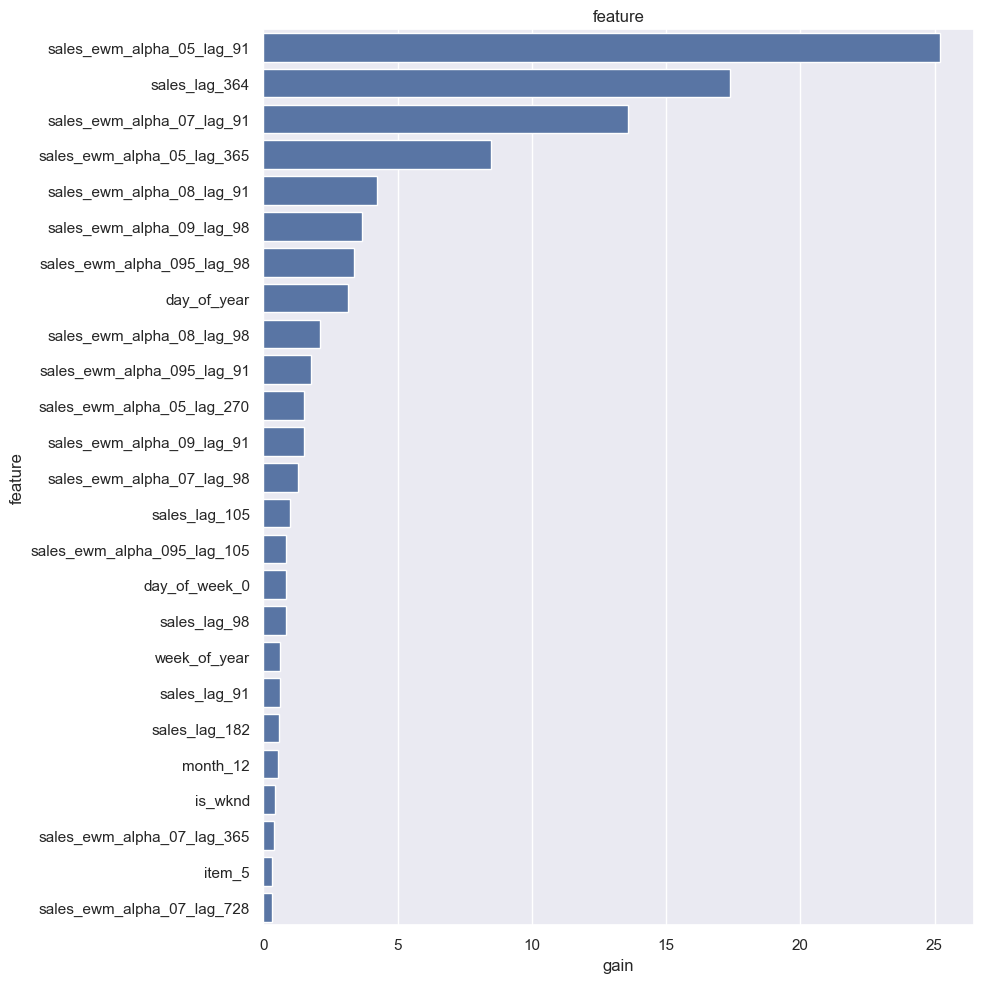

,feature,split,gain
54,sales_ewm_alpha_05_lag_91,381,25.210196
13,sales_lag_364,804,17.382099
45,sales_ewm_alpha_07_lag_91,193,13.568902
60,sales_ewm_alpha_05_lag_365,355,8.472209
36,sales_ewm_alpha_08_lag_91,104,4.254180
...,...,...,...
120,item_48,0,0.000000
111,item_39,0,0.000000
115,item_43,0,0.000000
137,month_8,0,0.000000


In [417]:
plot_lgb_importances(model,plot=True,num=10)

In [422]:
#önem sıralamasında split değeri 0 olanları kaldırabiliriz bu bize training süresinde avantaj sağlar, skorlama süresini kısaltır
feat_imp = plot_lgb_importances(model,plot=False,num=200)
importance_Zero = feat_imp[feat_imp["gain"] == 0]["feature"].values
imp_feats=[col for col in cols if col not in importance_Zero]
len(imp_feats)

                        feature  split       gain
54    sales_ewm_alpha_05_lag_91    381  25.210196
13                sales_lag_364    804  17.382099
45    sales_ewm_alpha_07_lag_91    193  13.568902
60   sales_ewm_alpha_05_lag_365    355   8.472209
36    sales_ewm_alpha_08_lag_91    104   4.254180
..                          ...    ...        ...
120                     item_48      0   0.000000
111                     item_39      0   0.000000
115                     item_43      0   0.000000
137                     month_8      0   0.000000
135                     month_6      0   0.000000

[142 rows x 3 columns]


123

In [418]:
#final model
train=df.loc[~df.sales.isna()]
Y_train=train['sales']
X_train=train[cols] #cols yerine imp_feats de kullanılabilir

In [419]:
test=df.loc[df.sales.isna()]
X_test=test[cols] #cols yerine imp_feats de kullanılabilir ?

In [420]:
lgb_params ={'num_leaves': 10,
            'learning_rate': 0.02, 
            "feature_fraction": 0.8, 
            'max_depth': 5,
            'verbose': 0, 
            'nthread': -1,
            'num_boost_round': model.best_iteration}    

In [423]:
lgbtrain_all=lgb.Dataset(data=X_train,label=Y_train,feature_name=cols)
final_model=lgb.train(lgb_params,lgbtrain_all,num_boost_round=model.best_iteration)


In [425]:
test_preds=final_model.predict(X_test,num_iteration=model.best_iteration)
print(test_preds)

[2.635359   2.71961878 2.70850059 ... 4.33595761 4.38188689 4.50007036]


In [ ]:
# Submission File